# Deep Learning HW2

Gerald Baulig 0780827 2019/12/02

GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we were asked to implement a Convolutional Neural Network (CNN) from scratch.
The CNN has to be demonstrated on two datasets:

1. The MNIST dataset of handwritten digits, and
2. The CIFAR-10 dataset with tiny images of 10 different classes.

# A CNN from Scratch


## Smart Indexing

In [1]:
import numpy as np
import numpy.matlib

def indices(xs, ks, stride=(1,1)):
    kn, kv, ku, kc = ks
    xn, xv, xu, xc = xs
    sv, su = stride
    
    def base(u, k, s):
        u = u+1-k
        K = np.arange(0, k)
        U = np.arange(0, u, s)
        us = U.size
        i = np.tile(K, us).reshape(us, k) + np.repeat(U, k).reshape(us, k)
        return i
    
    u = base(xu, ku, su)
    if xv is xu and kv is ku:
        v = u.copy()
    else:
        v = base(xv, kv, sv)
    
    shape = (max(v.shape[0],1), max(u.shape[0],1))
    u = np.matlib.repmat(u, shape[0], kv*xc).T
    v = np.matlib.repmat(v, 1, ku)
    v = np.repeat(v, shape[1], axis=0)
    v = np.repeat(v, xc, axis=1).T
    
    n = np.tile(np.arange(xn), kv*ku)[:,None] if xn > 1 else 0
    v = v if np.any(v) else 0
    u = u if np.any(u) else 0
    c = np.repeat(np.arange(xc), kv*ku)[:,None] if xc > 1 else 0
    return n, v, u, c, shape

## Test
def test_Indices():
    r = np.reshape(np.arange(5*5), (5,5))
    print("R: ", r.shape, "\n", r)
    n, v, u, c, shape = indices((1,5,5,1),(1,3,3,1),(1,1))
    print("U: ", u.shape, "\n", u)
    print("V: ", v.shape, "\n", v)
    r = r[v, u]
    print("R': ", r.shape, "\n", r)
test_Indices()

R:  (5, 5) 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
U:  (9, 9) 
 [[0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]]
V:  (9, 9) 
 [[0 0 0 1 1 1 2 2 2]
 [1 1 1 2 2 2 3 3 3]
 [2 2 2 3 3 3 4 4 4]
 [0 0 0 1 1 1 2 2 2]
 [1 1 1 2 2 2 3 3 3]
 [2 2 2 3 3 3 4 4 4]
 [0 0 0 1 1 1 2 2 2]
 [1 1 1 2 2 2 3 3 3]
 [2 2 2 3 3 3 4 4 4]]
R':  (9, 9) 
 [[ 0  1  2  5  6  7 10 11 12]
 [ 6  7  8 11 12 13 16 17 18]
 [12 13 14 17 18 19 22 23 24]
 [ 0  1  2  5  6  7 10 11 12]
 [ 6  7  8 11 12 13 16 17 18]
 [12 13 14 17 18 19 22 23 24]
 [ 0  1  2  5  6  7 10 11 12]
 [ 6  7  8 11 12 13 16 17 18]
 [12 13 14 17 18 19 22 23 24]]


## Padding

In [2]:
def padding(X, pad=(0,1,1,0)):
    shape = np.array(X.shape, dtype=int) + np.array(pad)*2
    Xp = np.zeros(shape)
    Xp[:,1:-1,1:-1,:] = X
    return Xp

## Test
def test_padding():
    Xp = padding(np.ones((1,5,5,1)))
    print(np.squeeze(Xp))
test_padding()

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


## The Kernel Convolution


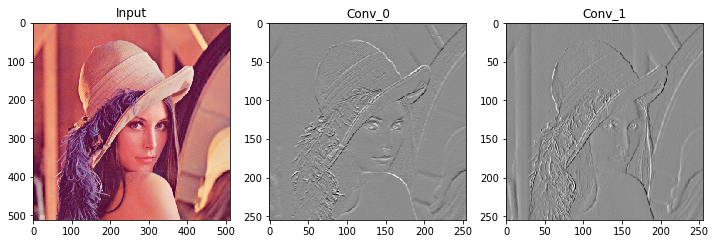

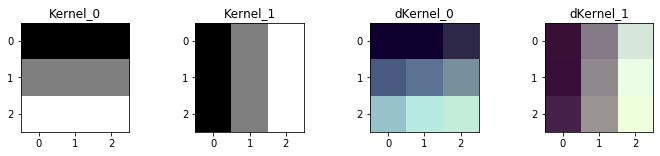

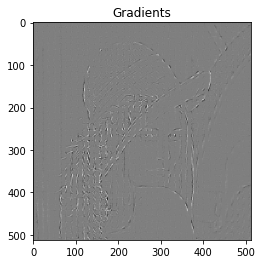

In [3]:
import numpy as np
from mynn import FeedFunc

def shape_nvuc(arr):
    if arr.ndim is 4:
        pass
    elif arr.ndim is 2:
        arr = arr[None,:,:,None,]
    elif arr.ndim is 3:
        arr = arr[None,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)

class Conv2D(FeedFunc):
    def __init__(self, stride=(1,1), pad=None):
        self.stride = stride
        self.uptodate = False
        self.pad = pad
        pass
    
    def f(self, X, K):
        X, xs = shape_nvuc(X)
        K, ks = shape_nvuc(K)
        if self.pad:
            X = padding(X, pad)
        
        if self.uptodate:
            self.uptodate = xs is self.xs and ks is self.ks
            pass
        
        if not self.uptodate:
            self.xs = xs
            self.ks = ks
            self.uptodate = True
            _, self.v, self.u, self.c, self.shape = indices(xs, ks, self.stride)
            K = K.transpose(0,3,1,2)
            self.ws = K.shape
            self.K = K.reshape(ks[0],-1)
            self.ys = (xs[0], xs[3], xs[1], xs[2])
            pass
        
        self.X = X[:,self.v,self.u,self.c].reshape(self.K.shape[1], -1)
        Y = np.dot(self.K, self.X)
        Y = Y.reshape(self.xs[0], -1, self.shape[0], self.shape[1])
        return Y.transpose(0,2,3,1)
    
    def dw(self, _X, dZ):
        self.dZ = dZ.transpose(0,3,1,2).reshape(-1, self.X.shape[1])
        dW = np.dot(self.dZ, self.X.T)
        dW = dW.reshape(self.ws)
        return dW.transpose(0,2,3,1)
    
    def dy(self, _dZ, _K):
        y = np.dot(self.K.T, self.dZ) 
        y = y.reshape(self.xs[0], np.prod(self.ks[1:]), -1)
        dY = np.zeros(self.ys)
        np.add.at(
            dY,
            (slice(None), self.c, self.v, self.u),
            y
        )
        return dY.transpose(0,2,3,1)
    
    def db(self, dZ):
        return dZ.sum(axis=(0,1,2))

##test
def cam_ready(x):
    x = np.squeeze(x)
    return x / np.abs(x).max() * 0.5 + 0.5

def test_Conv2D():
    %matplotlib inline
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255
    k = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
    k[0,0,:] = -1.
    k[0,2,:] = 1. ##horz. haar line filter
    k[1,:,0] = -1.
    k[1,:,2] = 1. ##vert. filter

    conv = Conv2D((2,2))
    y = conv.f(x, k)
    dw = conv.dw(x, y)
    dY = conv.dy(y, k)

    ## viz
    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,3)
    ax[0].set_title("Input")
    ax[0].imshow(x)
    
    for i, a in enumerate(ax[1:]):
        a.set_title("Conv_{}".format(i))
        a.imshow(cam_ready(y[0,:,:,i]), cmap='gray')
    plt.show()
    
    fig = plt.figure(figsize=(12,2))
    ax = fig.subplots(1,4)
    ax[0].set_title("Kernel_0")
    ax[0].imshow(cam_ready(k[0]))
    ax[1].set_title("Kernel_1")
    ax[1].imshow(cam_ready(k[1]))
    ax[2].set_title("dKernel_0")
    ax[2].imshow(cam_ready(dw[0]))
    ax[3].set_title("dKernel_1")
    ax[3].imshow(cam_ready(dw[1]))
    plt.show()
    
    plt.title("Gradients")
    plt.imshow(cam_ready(dY[0]))
    plt.show()
    
test_Conv2D()

## Max Pooling

Shape after pooling: (1, 170, 170, 1)


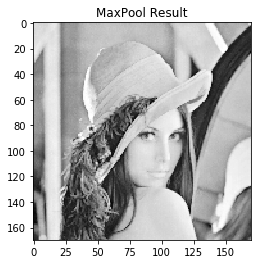

In [4]:
import numpy as np

class MaxPooling():
    def __init__(self,
                 indices,
                 input_func,
                 backprop
                ):
        ''''''
        self.input = input_func
        self.backprop = backprop
        _, self.v, self.u, self.c, self.shape = indices
        pass
    
    def pull_forward(self):
        for x in self.input():
            shape = (x.shape[0], self.shape[0], self.shape[1], -1)
            self.x = x[:,self.v,self.u,self.c]
            self.z = np.argmax(self.x, axis=1).T
            y = np.max(self.x, axis=1)
            self.y = y.reshape(shape)
            yield self.y
        pass
    
    def push_backward(self, dZ, lr):
        dZ = dZ.reshape(dZ.shape[0], -1)
        z = np.arange(self.dZ.shape[1])[:,None]
        dy = np.zeros(dZ.shape)
        dy[:,self.z,z] = dZ
        self.backprob(dy, lr)
        pass

## Test
def test_MaxPool():
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255
    x, xs = shape_nvuc(x)
    def gen_Lenna():
         yield x
    
    mp = MaxPooling(
        indices=indices(xs,(1,3,3,1),(3,3)),
        input_func=gen_Lenna,
        backprop=None
    )
    
    for y in mp.pull_forward():
        print("Shape after pooling:", y.shape)
    
    plt.imshow(cam_ready(y), cmap='gray')
    plt.title("MaxPool Result")
    plt.show()
    pass

test_MaxPool()

# 1. A CNN for MINIST

## Load n Prepare the MNIST Dataset

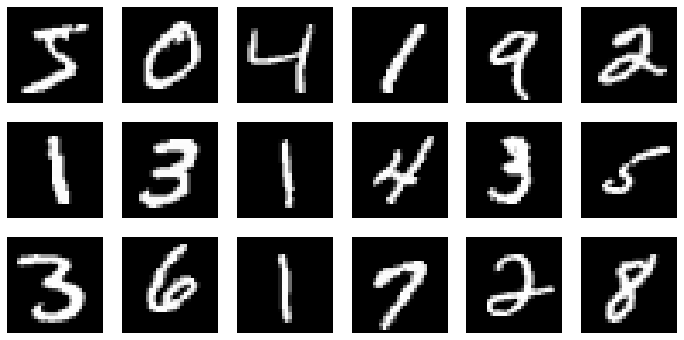

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8]
Input shape: (18, 28, 28, 1)


In [5]:
import numpy as np

def gen_UBYTES_data(filename, batch_size=1, split=1.0, norm=True, preload=False):
    #read header
    with open(filename, 'rb') as fid:
        mag = int.from_bytes(fid.read(4), byteorder='big')
        N = int.from_bytes(fid.read(4), byteorder='big')
        if mag == 2051:
            row = int.from_bytes(fid.read(4), byteorder='big')
            col = int.from_bytes(fid.read(4), byteorder='big')
        else:
            row = 1
            col = 1
        payload = fid.tell()
    
    #split
    if split > 0:
        N0 = 0
        N = int(N * split)
    else:
        N0 = N + int(N * split)
    
    #read payload batch wise
    step = 0
    if preload:
        with open(filename, 'rb') as fid:
            fid.seek(payload)
            batch = fid.read(N*row*col)
            pass
        
        batch = np.frombuffer(batch, dtype=np.uint8)
        if mag == 2051:
            if norm:
                batch = batch.astype(float) / 255
            batch = np.reshape(batch, (N, row, col, 1))
            
        for n in range(N0,N,batch_size):
            trail = batch_size - (n % batch_size)
            step += trail
            yield batch[n:n+trail], step
    else:
        for n in range(N0,N,batch_size):
            with open(filename, 'rb') as fid:
                fid.seek(payload+n)
                batch = fid.read(batch_size*row*col)
                pass

            batch = np.frombuffer(batch, dtype=np.uint8)
            trail = batch_size - (n % batch_size)
            step += trail
            if mag == 2051:
                if norm:
                    batch = batch.astype(float) / 255
                batch = np.reshape(batch, (trail, row, col, 1))
            yield batch, step
    pass

def to_hot_vector(labels, k):
    N = labels.shape[0] if len(labels.shape) else 1
    hot = np.zeros((N, 1, 1, k))
    hot[range(N),:,:,labels] = 1
    return hot

def gen_MNIST_data(
    data="train-images.idx3-ubyte",
    labels="train-labels.idx1-ubyte",
    batch_size=1,
    split = 1.0,
    norm=True,
    preload=False,
):
    gen_data = gen_UBYTES_data(data, batch_size, split, norm, preload)
    gen_labels = gen_UBYTES_data(labels, batch_size, split, norm, True)
    for data, label in zip(gen_data, gen_labels):
        X = data[0]
        T = to_hot_vector(label[0], 10)
        step = data[1]
        yield X, T, step

## test
def test_get_MNIST_data():
    %matplotlib inline
    import matplotlib.pylab as plt
    fig = plt.figure(figsize=(12,6))
    ax = fig.subplots(3,6)
    ax = np.reshape(ax, 6*3)

    ## get one batch and break
    for X, T, _ in gen_MNIST_data(
        "train-images.idx3-ubyte",
        "train-labels.idx1-ubyte",
        batch_size=6*3,
        norm=False
    ):
        for i, sample in enumerate(X):
            ax[i].set_axis_off()
            ax[i].imshow(np.squeeze(sample), cmap='gray')
        break
    plt.show()
    print("Labels:", np.where(T)[3])
    print("Input shape:", X.shape)
test_get_MNIST_data()

## Configure CNN for MNIST


In [6]:
import numpy as np
from mynn import (
    NeuralNetwork,
    Layer,
    CrossEntropy,
    ArgMaxPooling,
    ReLU,
    Sigmoid
)

def init_params(c, u, v, n, bias=True, init_func=np.random.randn):
    '''Initialize parameters.
    
    Args:
        c: Number of channels of the kernel
        u, v: shape of the kernel.
        n: Number of kernels.
        bias: True, if a bias should be used, otherwise False.
        init_func: Alter the initialization function.
            (default) np.random.randn
    Returns:
        kernels: A 4-dimensional matrix of weights.
        bias: Either 0 or a vector of biases for each node.
    '''
    kernels = init_func(n, v, u, c)
    return kernels, np.zeros(n) if bias else 0

def init_MNIST_cnn(batch_size):
    '''
    '''
    cnn = NeuralNetwork(
        train_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            batch_size,
            split=0.8
        ),
        val_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            batch_size,
            split=-0.2
        ),
        cost_func=CrossEntropy,
        loss_func=ArgMaxPooling
    )
    
    cnn.In = Layer(
        params=init_params(1,3,3,10),
        feed_func=Conv2D(stride=(2,2)),
        input_func=cnn.gen_input,
        backprop=None,
        act_func = ReLU
    ) #(28-2)/2=13
    
    cnn.Conv1 = Layer(
        params=init_params(10,4,4,10),
        feed_func=Conv2D(stride=(2,2)),
        input_func=cnn.In.pull_forward,
        backprop=cnn.In.push_backward,
        act_func = ReLU
    ) #(13-3)/2=5
    
    cnn.Out = Layer(
        params=init_params(10,5,5,10),
        feed_func=Conv2D(stride=(1,1)),
        input_func=cnn.Conv1.pull_forward,
        backprop=cnn.Conv1.push_backward,
        act_func = Sigmoid(1000)
    ) #(5-4)/1=1
    return cnn

cnn = init_MNIST_cnn(1)
print(cnn.__dict__)

{'train_set': <function init_MNIST_cnn.<locals>.<lambda> at 0x0000021642375C18>, 'val_set': <function init_MNIST_cnn.<locals>.<lambda> at 0x0000021642375D38>, 'cost': <class 'mynn.LossFunctions.CrossEntropy'>, 'loss': <class 'mynn.LossFunctions.ArgMaxPooling'>, 'training': False, 'step': 0, 'In': <mynn.Layer.Layer object at 0x000002164284C688>, 'Conv1': <mynn.Layer.Layer object at 0x000002164284C6C8>, 'Out': <mynn.Layer.Layer object at 0x000002164284C848>}


## Train CNN for MNIST

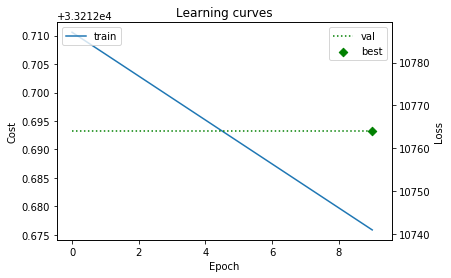

Best Epoch: 9 with a Loss of: 10764


(9, 10764)

In [7]:
from mynn.Tools import train_n_plot

np.random.seed(1)
epochs = 10
batch_size = 6000
lr = 1e-10
lr_dec = 1e-1
model_name = "mnist_cnn"
ckpts = 1

cnn = init_MNIST_cnn(batch_size)

train_n_plot(cnn, epochs, lr, lr_dec, model_name, ckpts)

In [8]:
import matplotlib.pylab as plt

cnn.val_set = lambda: gen_MNIST_data(
    "train-images.idx3-ubyte",
    "train-labels.idx1-ubyte",
    batch_size=1,
    split=-0.2
)

for Z in cnn.val(cnn.Out):
    t = np.argmax(np.squeeze(cnn.T))
    y = np.argmax(np.squeeze(cnn.Out.y))
    print("Target:", t, "Prediction:", y, "Match:", t == y)
    pass

Target: 4 Prediction: 8 Match: False
Target: 7 Prediction: 8 Match: False
Target: 8 Prediction: 3 Match: False
Target: 8 Prediction: 3 Match: False
Target: 5 Prediction: 3 Match: False
Target: 6 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 2 Prediction: 1 Match: False
Target: 2 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 4 Prediction: 0 Match: False
Target: 3 Prediction: 9 Match: False
Target: 4 Prediction: 8 Match: False
Target: 5 Prediction: 8 Match: False
Target: 2 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 2 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 0 Prediction: 8 Match: False
Target: 0 Prediction: 8 Match: False
Ta

Target: 1 Prediction: 1 Match: True
Target: 0 Prediction: 1 Match: False
Target: 7 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 2 Prediction: 4 Match: False
Target: 6 Prediction: 8 Match: False
Target: 4 Prediction: 4 Match: True
Target: 7 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 2 Prediction: 5 Match: False
Target: 5 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Tar

Target: 0 Prediction: 0 Match: True
Target: 2 Prediction: 1 Match: False
Target: 1 Prediction: 4 Match: False
Target: 2 Prediction: 4 Match: False
Target: 2 Prediction: 5 Match: False
Target: 1 Prediction: 6 Match: False
Target: 3 Prediction: 6 Match: False
Target: 4 Prediction: 6 Match: False
Target: 4 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 4 Prediction: 5 Match: False
Target: 6 Prediction: 6 Match: True
Target: 8 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 2 Prediction: 5 Match: False
Target: 8 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 3 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 3 Prediction: 3 Match: True
Target: 2 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 3 Prediction: 1 Match: False
Target

Target: 4 Prediction: 6 Match: False
Target: 7 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 8 Match: False
Target: 2 Prediction: 9 Match: False
Target: 3 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 9 Prediction: 6 Match: False
Target: 6 Prediction: 6 Match: True
Target: 0 Prediction: 6 Match: False
Target: 0 Prediction: 6 Match: False
Ta

Target: 1 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 9 Prediction: 8 Match: False
Target: 6 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 1 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 2 Prediction: 3 Match: False
Target: 7 Prediction: 3 Match: False
Target: 4 Prediction: 3 Match: False
Target: 2 Prediction: 3 Match: False
Target: 7 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 4 Prediction: 3 Match: False
Ta

Target: 4 Prediction: 4 Match: True
Target: 9 Prediction: 6 Match: False
Target: 2 Prediction: 6 Match: False
Target: 8 Prediction: 6 Match: False
Target: 3 Prediction: 6 Match: False
Target: 1 Prediction: 6 Match: False
Target: 2 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 8 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 0 Prediction: 1 Match: False
Target: 1 Prediction: 1 Match: True
Target: 7 Prediction: 1 Match: False
Target: 3 Prediction: 1 Match: False
Tar

Target: 6 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 6 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 3 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 2 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 6 Prediction: 6 Match: True
Target: 0 Prediction: 6 Match: False
Target: 1 Prediction: 6 Match: False
Target: 2 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 5 Prediction: 5 Match: True
Target: 2 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Targe

Target: 9 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 3 Prediction: 8 Match: False
Target: 4 Prediction: 8 Match: False
Target: 4 Prediction: 8 Match: False
Target: 3 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 3 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 3 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 9 Prediction: 8 Match: False
Target: 0 Prediction: 5 Match: False
Target: 5 Prediction: 8 Match: False
Target: 6 Prediction: 3 Match: False
Target: 8 Prediction: 3 Match: False
Target: 8 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 1 Prediction: 9 Match: False
Target: 4 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Tar

Target: 9 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 1 Prediction: 0 Match: False
Target: 5 Prediction: 4 Match: False
Target: 6 Prediction: 0 Match: False
Target: 8 Prediction: 4 Match: False
Target: 1 Prediction: 4 Match: False
Target: 0 Prediction: 0 Match: True
Target: 5 Prediction: 4 Match: False
Target: 7 Prediction: 4 Match: False
Target: 5 Prediction: 5 Match: True
Target: 3 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 3 Prediction: 5 Match: False
Target: 4 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 1 Prediction: 3 Match: False
Target: 6 Prediction: 3 Match: False
Target: 8 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 0 Prediction: 3 Match: False
Target: 9 Prediction: 3 Match: False
Target: 5 Prediction: 3 Match: False
Target: 7 Prediction: 3 Match: False
Target

Target: 8 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 8 Prediction: 6 Match: False
Target: 7 Prediction: 5 Match: False
Target: 8 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 9 Prediction: 5 Match: False
Target: 1 Prediction: 6 Match: False
Target: 7 Prediction: 6 Match: False
Target: 6 Prediction: 9 Match: False
Target: 0 Prediction: 0 Match: True
Target: 9 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 9 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 1 Prediction: 0 Match: False
Target: 3 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 8 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 5 Prediction: 5 Match: True
Tar

Target: 1 Prediction: 8 Match: False
Target: 0 Prediction: 8 Match: False
Target: 9 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 7 Prediction: 5 Match: False
Target: 5 Prediction: 8 Match: False
Target: 1 Prediction: 8 Match: False
Target: 2 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 7 Prediction: 6 Match: False
Target: 3 Prediction: 6 Match: False
Target: 9 Prediction: 8 Match: False
Target: 3 Prediction: 8 Match: False
Target: 7 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 3 Prediction: 9 Match: False
Target: 0 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 7 Prediction: 3 Match: False
T

Target: 1 Prediction: 4 Match: False
Target: 6 Prediction: 4 Match: False
Target: 4 Prediction: 4 Match: True
Target: 5 Prediction: 4 Match: False
Target: 9 Prediction: 5 Match: False
Target: 6 Prediction: 4 Match: False
Target: 6 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 5 Prediction: 1 Match: False
Target: 3 Prediction: 1 Match: False
Target: 8 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 1 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 6 Prediction: 4 Match: False
Target: 3 Prediction: 4 Match: False
Target: 7 Prediction: 4 Match: False
Target: 5 Prediction: 4 Match: False
Tar

Target: 9 Prediction: 5 Match: False
Target: 9 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 4 Prediction: 5 Match: False
Target: 9 Prediction: 9 Match: True
Target: 4 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 0 Prediction: 9 Match: False
Target: 5 Prediction: 5 Match: True
Target: 9 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Targ

Target: 7 Prediction: 8 Match: False
Target: 6 Prediction: 0 Match: False
Target: 1 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 2 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 5 Prediction: 8 Match: False
Target: 7 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 5 Prediction: 2 Match: False
Target: 8 Prediction: 2 Match: False
Target: 7 Prediction: 2 Match: False
Target: 6 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 3 Prediction: 3 Match: True
Ta

Target: 7 Prediction: 3 Match: False
Target: 8 Prediction: 1 Match: False
Target: 0 Prediction: 1 Match: False
Target: 4 Prediction: 9 Match: False
Target: 6 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 0 Prediction: 5 Match: False
Target: 8 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 6 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 7 Prediction: 4 Match: False
Target: 2 Prediction: 4 Match: False
Target: 8 Prediction: 4 Match: False
Target: 4 Prediction: 5 Match: False
Target: 8 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 4 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 0 Prediction: 9 Match: False
Target: 3 Prediction: 3 Match: True
Ta

Target: 2 Prediction: 1 Match: False
Target: 2 Prediction: 1 Match: False
Target: 3 Prediction: 4 Match: False
Target: 1 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 5 Prediction: 6 Match: False
Target: 1 Prediction: 6 Match: False
Target: 3 Prediction: 9 Match: False
Target: 1 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 5 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 3 Prediction: 3 Match: True
Target: 5 Prediction: 5 Match: True
Target: 1 Prediction: 9 Match: False
Target: 1 Prediction: 1 Match: True
Target: 8 Prediction: 4 Match: False
Target: 1 Prediction: 1 Match: True
Target: 2 Prediction: 1 Match: False
Target

Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 1 Prediction: 9 Match: False
Target: 8 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 2 Prediction: 9 Match: False
Target: 6 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 3 Prediction: 0 Match: False
Target: 4 Prediction: 1 Match: False
Target: 5 Prediction: 1 Match: False
Target: 5 Prediction: 1 Match: False
Target: 5 Prediction: 6 Match: False
Target: 5 Prediction: 6 Match: False
Target: 9 Prediction: 6 Match: False
Target: 0 Prediction: 6 Match: False
Target: 3 Prediction: 6 Match: False
Target: 3 Prediction: 6 Match: False
Target: 5 Prediction: 5 Match: True
Target: 1 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 6 Prediction: 9 Match: False
Target: 7 Prediction: 8 Match: False
Target: 9 Prediction: 5 Match: False
Targ

Target: 5 Prediction: 8 Match: False
Target: 1 Prediction: 8 Match: False
Target: 0 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 2 Prediction: 8 Match: False
Target: 5 Prediction: 5 Match: True
Target: 3 Prediction: 8 Match: False
Target: 0 Prediction: 8 Match: False
Target: 6 Prediction: 8 Match: False
Target: 9 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 8 Prediction: 3 Match: False
Target: 9 Prediction: 3 Match: False
Target: 3 Prediction: 3 Match: True
Target: 0 Prediction: 8 Match: False
Target: 8 Prediction: 8 Match: True
Target: 3 Prediction: 3 Match: True
Target: 0 Prediction: 3 Match: False
Target: 5 Prediction: 3 Match: False
Target: 3 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 0 Prediction: 8 Match: False
Targe

Target: 7 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 9 Prediction: 4 Match: False
Target: 2 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 4 Prediction: 6 Match: False
Target: 6 Prediction: 6 Match: True
Target: 0 Prediction: 5 Match: False
Target: 4 Prediction: 9 Match: False
Target: 1 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 8 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 5 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 9 Prediction: 9 Match: True
Target: 3 Prediction: 9 Match: False
Tar

Target: 2 Prediction: 4 Match: False
Target: 8 Prediction: 6 Match: False
Target: 7 Prediction: 6 Match: False
Target: 1 Prediction: 9 Match: False
Target: 4 Prediction: 6 Match: False
Target: 9 Prediction: 9 Match: True
Target: 2 Prediction: 9 Match: False
Target: 6 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 5 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 5 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 6 Prediction: 3 Match: False
Target: 4 Prediction: 3 Match: False
Target: 6 Prediction: 5 Match: False
Target: 4 Prediction: 0 Match: False
Target: 6 Prediction: 1 Match: False
Target: 4 Prediction: 2 Match: False
Target: 0 Prediction: 2 Match: False
Target: 1 Prediction: 2 Match: False
Tar

Target: 4 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 7 Prediction: 8 Match: False
Target: 1 Prediction: 8 Match: False
Target: 7 Prediction: 8 Match: False
Target: 8 Prediction: 9 Match: False
Target: 4 Prediction: 8 Match: False
Target: 7 Prediction: 0 Match: False
Target: 7 Prediction: 3 Match: False
Target: 5 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 5 Prediction: 0 Match: False
Target: 3 Prediction: 1 Match: False
Target: 1 Prediction: 2 Match: False
Target: 6 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 7 Prediction: 5 Match: False
Target: 1 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 4 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 7 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
T

Target: 4 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 7 Prediction: 1 Match: False
Target: 1 Prediction: 1 Match: True
Target: 3 Prediction: 1 Match: False
Target: 1 Prediction: 1 Match: True
Target: 8 Prediction: 0 Match: False
Target: 7 Prediction: 4 Match: False
Target: 5 Prediction: 4 Match: False
Target: 2 Prediction: 4 Match: False
Target: 3 Prediction: 6 Match: False
Target: 4 Prediction: 9 Match: False
Target: 3 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 9 Prediction: 6 Match: False
Target: 0 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 1 Prediction: 0 Match: False
Tar

Target: 0 Prediction: 6 Match: False
Target: 9 Prediction: 6 Match: False
Target: 6 Prediction: 6 Match: True
Target: 6 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 5 Prediction: 5 Match: True
Target: 9 Prediction: 2 Match: False
Target: 8 Prediction: 5 Match: False
Target: 9 Prediction: 0 Match: False
Target: 4 Prediction: 9 Match: False
Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 7 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 6 Prediction: 5 Match: False
Target: 9 Prediction: 9 Match: True
Target: 9 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 6 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Targe

Target: 4 Prediction: 9 Match: False
Target: 1 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 0 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 0 Prediction: 0 Match: True
Target: 5 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 4 Prediction: 3 Match: False
Target: 8 Prediction: 3 Match: False
Target: 7 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 0 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 4 Prediction: 8 Match: False
Target: 4 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Ta

Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 2 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 3 Prediction: 1 Match: False
Target: 8 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 4 Prediction: 8 Match: False
Target: 5 Prediction: 5 Match: True
Target: 9 Prediction: 0 Match: False
Target: 6 Prediction: 5 Match: False
Target: 0 Prediction: 0 Match: True
Target: 7 Prediction: 9 Match: False
Target: 9 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 9 Prediction: 5 Match: False
Target: 9 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 0 Prediction: 4 Match: False
Target: 8 Prediction: 4 Match: False
Target: 1 Prediction: 5 Match: False
Target: 3 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 3 Prediction: 8 Match: False
Target: 2 Prediction: 8 Match: False
Target: 4 Prediction: 4 Match: True
Target

Target: 4 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 1 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 9 Prediction: 0 Match: False
Target: 0 Prediction: 1 Match: False
Target: 0 Prediction: 1 Match: False
Target: 6 Prediction: 1 Match: False
Target: 1 Prediction: 1 Match: True
Target: 5 Prediction: 1 Match: False
Target: 2 Prediction: 2 Match: True
Target: 5 Prediction: 2 Match: False
Target: 3 Prediction: 3 Match: True
Target: 0 Prediction: 5 Match: False
Targ

Target: 7 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 9 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 5 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 9 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 3 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 6 Match: False
Target: 6 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 6 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 2 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Tar

Target: 7 Prediction: 3 Match: False
Target: 7 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 9 Prediction: 4 Match: False
Target: 6 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 9 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 1 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 8 Prediction: 9 Match: False
Target: 1 Prediction: 8 Match: False
Target: 9 Prediction: 8 Match: False
Target: 6 Prediction: 0 Match: False
Targ

Target: 5 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 0 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 6 Prediction: 9 Match: False
Target: 3 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 1 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 1 Prediction: 3 Match: False
Target: 0 Prediction: 3 Match: False
Target: 0 Prediction: 3 Match: False
Target: 6 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 8 Prediction: 3 Match: False
Target: 2 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 3 Prediction: 1 Match: False
Target: 3 Prediction: 1 Match: False
Target: 4 Prediction: 1 Match: False
Target: 6 Prediction: 1 Match: False
Target: 5 Prediction: 0 Match: False
Target: 0 Prediction: 6 Match: False
Target: 6 Prediction: 6 Match: True
Target: 3 Prediction: 6 Match: False
Target: 7 Prediction: 6 Match: False
Target: 8 Prediction: 6 Match: False
Targe

Target: 6 Prediction: 5 Match: False
Target: 2 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 0 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 5 Prediction: 0 Match: False
Target: 2 Prediction: 1 Match: False
Target: 6 Prediction: 1 Match: False
Target: 8 Prediction: 1 Match: False
Target: 9 Prediction: 1 Match: False
Target: 0 Prediction: 0 Match: True
Target: 3 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 3 Prediction: 5 Match: False
Target: 9 Prediction: 9 Match: True
Target: 6 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 0 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Targ

Target: 2 Prediction: 4 Match: False
Target: 2 Prediction: 4 Match: False
Target: 3 Prediction: 0 Match: False
Target: 9 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 5 Prediction: 5 Match: True
Target: 6 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 7 Prediction: 8 Match: False
Target: 1 Prediction: 8 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 9 Prediction: 2 Match: False
Target: 3 Prediction: 1 Match: False
Target: 7 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Targ

Target: 4 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 1 Prediction: 4 Match: False
Target: 6 Prediction: 4 Match: False
Target: 2 Prediction: 3 Match: False
Target: 7 Prediction: 3 Match: False
Target: 1 Prediction: 3 Match: False
Target: 8 Prediction: 3 Match: False
Target: 3 Prediction: 3 Match: True
Target: 9 Prediction: 3 Match: False
Target: 6 Prediction: 3 Match: False
Target: 0 Prediction: 1 Match: False
Target: 2 Prediction: 1 Match: False
Target: 1 Prediction: 1 Match: True
Target: 4 Prediction: 1 Match: False
Target: 2 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 3 Prediction: 4 Match: False
Target: 5 Prediction: 4 Match: False
Target: 4 Prediction: 4 Match: True
Target: 1 Prediction: 4 Match: False
Target: 5 Prediction: 4 Match: False
Target: 2 Prediction: 4 Match: False
Target: 6 Prediction: 4 Match: False
Target: 4 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Targe

Target: 2 Prediction: 2 Match: True
Target: 4 Prediction: 2 Match: False
Target: 3 Prediction: 2 Match: False
Target: 3 Prediction: 2 Match: False
Target: 4 Prediction: 2 Match: False
Target: 3 Prediction: 2 Match: False
Target: 6 Prediction: 9 Match: False
Target: 4 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 8 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 6 Prediction: 0 Match: False
Target: 7 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 4 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 9 Prediction: 9 Match: True
Target: 9 Prediction: 0 Match: False
Target: 9 Prediction: 1 Match: False
Target

Target: 8 Prediction: 6 Match: False
Target: 4 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 5 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 7 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 0 Prediction: 8 Match: False
Target: 1 Prediction: 8 Match: False
Target: 1 Prediction: 8 Match: False
Target: 4 Prediction: 8 Match: False
Target: 2 Prediction: 8 Match: False
Target: 8 Prediction: 3 Match: False
Target: 3 Prediction: 3 Match: True
Target: 9 Prediction: 0 Match: False
Target: 4 Prediction: 3 Match: False
Target: 5 Prediction: 3 Match: False
Target: 5 Prediction: 9 Match: False
Target: 3 Prediction: 0 Match: False
Target: 6 Prediction: 2 Match: False
Target: 6 Prediction: 0 Match: False
Tar

Target: 1 Prediction: 3 Match: False
Target: 4 Prediction: 1 Match: False
Target: 3 Prediction: 1 Match: False
Target: 5 Prediction: 1 Match: False
Target: 5 Prediction: 1 Match: False
Target: 6 Prediction: 2 Match: False
Target: 1 Prediction: 2 Match: False
Target: 7 Prediction: 0 Match: False
Target: 9 Prediction: 3 Match: False
Target: 8 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 9 Prediction: 6 Match: False
Target: 6 Prediction: 6 Match: True
Target: 0 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 1 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 3 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 5 Prediction: 5 Match: True
Target: 5 Prediction: 5 Match: True
Target: 7 Prediction: 8 Match: False
Target: 6 Prediction: 3 Match: False
Target: 5 Prediction: 3 Match: False
Targe

Target: 5 Prediction: 4 Match: False
Target: 4 Prediction: 4 Match: True
Target: 0 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 8 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 0 Prediction: 0 Match: True
Target: 9 Prediction: 9 Match: True
Target: 4 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 3 Prediction: 0 Match: False
Target: 1 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 2 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 9 Prediction: 4 Match: False
Target: 7 Prediction: 4 Match: False
Targe

Target: 1 Prediction: 9 Match: False
Target: 1 Prediction: 3 Match: False
Target: 3 Prediction: 1 Match: False
Target: 2 Prediction: 1 Match: False
Target: 9 Prediction: 1 Match: False
Target: 3 Prediction: 2 Match: False
Target: 4 Prediction: 2 Match: False
Target: 4 Prediction: 4 Match: True
Target: 2 Prediction: 0 Match: False
Target: 5 Prediction: 4 Match: False
Target: 7 Prediction: 0 Match: False
Target: 6 Prediction: 6 Match: True
Target: 8 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 8 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 7 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 2 Prediction: 8 Match: False
Target: 2 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Targ

Target: 1 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 9 Prediction: 5 Match: False
Target: 1 Prediction: 8 Match: False
Target: 0 Prediction: 8 Match: False
Target: 6 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 3 Prediction: 0 Match: False
Target: 2 Prediction: 3 Match: False
Target: 4 Prediction: 3 Match: False
Target: 3 Prediction: 3 Match: True
Target: 9 Prediction: 9 Match: True
Target: 4 Prediction: 1 Match: False
Target: 1 Prediction: 1 Match: True
Target: 5 Prediction: 1 Match: False
Target: 6 Prediction: 0 Match: False
Target: 6 Prediction: 7 Match: False
Target: 5 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 9 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Targe

Target: 4 Prediction: 1 Match: False
Target: 1 Prediction: 1 Match: True
Target: 6 Prediction: 1 Match: False
Target: 2 Prediction: 0 Match: False
Target: 3 Prediction: 1 Match: False
Target: 3 Prediction: 4 Match: False
Target: 8 Prediction: 4 Match: False
Target: 4 Prediction: 4 Match: True
Target: 8 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 1 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 7 Prediction: 5 Match: False
Target: 0 Prediction: 9 Match: False
Target: 8 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 9 Prediction: 9 Match: True
Target: 6 Prediction: 9 Match: False
Target: 0 Prediction: 0 Match: True
Target: 5 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 9 Prediction: 1 Match: False
Target:

Target: 9 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 8 Prediction: 8 Match: True
Target: 6 Prediction: 5 Match: False
Target: 0 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 8 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 1 Prediction: 9 Match: False
Target: 0 Prediction: 0 Match: True
Target: 1 Prediction: 0 Match: False
Target: 1 Prediction: 2 Match: False
Target: 4 Prediction: 1 Match: False
Target: 2 Prediction: 1 Match: False
Target: 6 Prediction: 3 Match: False
Target: 3 Prediction: 3 Match: True
Target: 4 Prediction: 3 Match: False
Target: 4 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 5 Prediction: 6 Match: False
Target: 5 Prediction: 5 Match: True
Target:

Target: 7 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 0 Prediction: 8 Match: False
Target: 9 Prediction: 5 Match: False
Target: 1 Prediction: 6 Match: False
Target: 1 Prediction: 6 Match: False
Target: 2 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 3 Prediction: 8 Match: False
Target: 7 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 5 Prediction: 5 Match: True
Target: 6 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 8 Prediction: 3 Match: False
Target: 3 Prediction: 3 Match: True
Target: 9 Prediction: 3 Match: False
Target: 5 Prediction: 1 Match: False
Target: 0 Prediction: 3 Match: False
Targ

Target: 0 Prediction: 5 Match: False
Target: 9 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 0 Prediction: 0 Match: True
Target: 4 Prediction: 3 Match: False
Target: 9 Prediction: 3 Match: False
Target: 3 Prediction: 3 Match: True
Target: 4 Prediction: 3 Match: False
Target: 6 Prediction: 3 Match: False
Target: 7 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 2 Prediction: 1 Match: False
Target: 0 Prediction: 1 Match: False
Target: 8 Prediction: 1 Match: False
Target: 8 Prediction: 1 Match: False
Target: 3 Prediction: 1 Match: False
Target: 9 Prediction: 1 Match: False
Target: 0 Prediction: 3 Match: False
Target: 8 Prediction: 4 Match: False
Target: 7 Prediction: 6 Match: False
Target: 7 Prediction: 6 Match: False
Target: 4 Prediction: 6 Match: False
Target: 0 Prediction: 6 Match: False
Target: 4 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Targe

Target: 0 Prediction: 0 Match: True
Target: 7 Prediction: 6 Match: False
Target: 5 Prediction: 6 Match: False
Target: 7 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 4 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 5 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 6 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Ta

Target: 2 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 6 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 0 Prediction: 9 Match: False
Target: 1 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 3 Prediction: 0 Match: False
Target: 4 Prediction: 0 Match: False
Target: 5 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 9 Prediction: 2 Match: False
Target: 0 Prediction: 6 Match: False
Target: 1 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 9 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Ta

Target: 9 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 5 Prediction: 1 Match: False
Target: 6 Prediction: 0 Match: False
Target: 8 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 3 Prediction: 4 Match: False
Target: 9 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 6 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 2 Prediction: 8 Match: False
Target: 5 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 3 Prediction: 3 Match: True
Target: 9 Prediction: 3 Match: False
Target: 6 Prediction: 1 Match: False
Target: 8 Prediction: 1 Match: False
Target: 7 Prediction: 1 Match: False
Target: 9 Prediction: 0 Match: False
Target: 1 Prediction: 0 Match: False
Targ

Target: 9 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 9 Prediction: 9 Match: True
Target: 3 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 3 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 0 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 0 Prediction: 1 Match: False
Target: 4 Prediction: 1 Match: False
Target: 2 Prediction: 1 Match: False
Target: 6 Prediction: 1 Match: False
Target: 5 Prediction: 0 Match: False
Target: 3 Prediction: 4 Match: False
Target: 5 Prediction: 4 Match: False
Target: 3 Prediction: 6 Match: False
Target: 8 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Targ

Target: 0 Prediction: 6 Match: False
Target: 6 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 1 Prediction: 8 Match: False
Target: 7 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 4 Prediction: 3 Match: False
Target: 2 Prediction: 3 Match: False
Target: 0 Prediction: 3 Match: False
Target: 9 Prediction: 3 Match: False
Target: 7 Prediction: 3 Match: False
Target: 6 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 4 Prediction: 8 Match: False
Target: 1 Prediction: 8 Match: False
Target: 6 Prediction: 8 Match: False
Target: 8 Prediction: 8 Match: True
Target: 4 Prediction: 8 Match: False
Target: 7 Prediction: 6 Match: False
Target: 5 Prediction: 6 Match: False
Tar

Target: 7 Prediction: 5 Match: False
Target: 3 Prediction: 8 Match: False
Target: 3 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 4 Prediction: 1 Match: False
Target: 9 Prediction: 1 Match: False
Target: 8 Prediction: 1 Match: False
Target: 8 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 9 Prediction: 5 Match: False
Target: 6 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 5 Prediction: 6 Match: False
Target: 9 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 3 Prediction: 5 Match: False
Target: 7 Prediction: 9 Match: False
Target: 4 Prediction: 5 Match: False
Target: 7 Prediction: 0 Match: False
Target: 6 Prediction: 0 Match: False
Target: 0 Prediction: 4 Match: False
Target: 0 Prediction: 9 Match: False
Target: 4 Prediction: 3 Match: False
Tar

Target: 7 Prediction: 0 Match: False
Target: 5 Prediction: 1 Match: False
Target: 3 Prediction: 0 Match: False
Target: 5 Prediction: 5 Match: True
Target: 3 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 2 Match: True
Target: 3 Prediction: 9 Match: False
Target: 4 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 6 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 0 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 6 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 0 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 2 Prediction: 0 Match: False
Targe

Target: 4 Prediction: 4 Match: True
Target: 8 Prediction: 9 Match: False
Target: 4 Prediction: 0 Match: False
Target: 6 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 0 Prediction: 5 Match: False
Target: 1 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 4 Prediction: 5 Match: False
Target: 5 Prediction: 5 Match: True
Target: 6 Prediction: 9 Match: False
Target: 7 Prediction: 9 Match: False
Target: 8 Prediction: 9 Match: False
Target: 9 Prediction: 9 Match: True
Target: 0 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 4 Prediction: 3 Match: False
Target: 5 Prediction: 9 Match: False
Target: 6 Prediction: 0 Match: False
Target: 7 Prediction: 0 Match: False
Target: 8 Prediction: 0 Match: False
Target: 9 Prediction: 0 Match: False
Target: 0 Prediction: 0 Match: True
Target: 1 Prediction: 4 Match: False
Targe

Target: 8 Prediction: 5 Match: False
Target: 9 Prediction: 5 Match: False
Target: 3 Prediction: 5 Match: False
Target: 2 Prediction: 5 Match: False
Target: 9 Prediction: 9 Match: True
Target: 3 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 1 Prediction: 9 Match: False
Target: 4 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 5 Prediction: 9 Match: False
Target: 2 Prediction: 9 Match: False
Target: 3 Prediction: 9 Match: False
Target: 2 Prediction: 0 Match: False
Target: 1 Prediction: 9 Match: False
Target: 3 Prediction: 0 Match: False
Target: 9 Prediction: 6 Match: False
Target: 7 Prediction: 0 Match: False
Target: 2 Prediction: 0 Match: False
Target: 1 Prediction: 9 Match: False
Target: 2 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 9 Prediction: 4 Match: False
Target: 1 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 8 Prediction: 5 Match: False
Target: 7 Prediction: 5 Match: False
Ta